In [1]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from pyemd import emd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def combine(state, goal):
    if state is None:
        return None
    return torch.cat((state, goal), 1)

In [3]:
class miniDQN(nn.Module):

    def __init__(self, hidden):
        super(miniDQN, self).__init__()
        self.W1 = nn.Linear(8, hidden) # state + goal
        self.W2 = nn.Linear(hidden, 4)
        nn.init.xavier_uniform_(self.W1.weight)
        nn.init.xavier_uniform_(self.W2.weight)

    def forward(self, x):
        x = F.relu(self.W1(x))
        return self.W2(x)

#For now, embedding on states (not state-action pairs) because we're lazy
class embeddingNN(nn.Module):

    def __init__(self, hidden, output):
        super(embeddingNN, self).__init__()
        self.W1 = nn.Linear(8, hidden) # state + goal
        self.W2 = nn.Linear(hidden, output)
        nn.init.xavier_uniform_(self.W1.weight)
        nn.init.xavier_uniform_(self.W2.weight)

    def forward(self, x):
        x = F.relu(self.W1(x))
        return self.W2(x)

In [4]:
num_row = 10
num_col = 10

action_direction = [(0,1), (0,-1), (1,0), (-1,0)]

reds = [(3,0)]
blues = [(0,3)]
walls = []

start_state = np.asarray([0,0,0,0])
end_state = np.asarray([4,4,1,1])
torch_end = torch.from_numpy(end_state).float().unsqueeze(0)

RANDOM_ACTION_EPSILON = 0.1

def is_done(s):
    return np.array_equal(s, end_state)

def step(s, a):
    row, col, blue, red = tuple(s)
    if np.random.random() < RANDOM_ACTION_EPSILON:
        a = np.random.choice(4)
    a_row, a_col = action_direction[a]

    row = row + a_row
    col = col + a_col

    if row < 0 or row >= num_row or col < 0 or col >= num_col or (row, col) in walls:
        return s

    blue = blue or (row, col) in blues
    red = red or (row, col) in reds

    return np.asarray((row, col, blue, red))

def get_reward(s, a, s_prime):
    if is_done(s):
        return 0.0
    return -1.0

def L1(s1, s2):
    return 1.0 * np.sum(np.abs(np.asarray(s1) - np.asarray(s2)))

In [5]:
#Very adhoc, requires reversible dynamics
distance_cache = {}

def distance(a, b):
    global distance_cache
    ta = tuple(a)
    tb = tuple(b)
    if (ta,tb) in distance_cache:
        return distance_cache[(ta,tb)]
    
    row_a, col_a, blue_a, red_a = ta
    row_b, col_b, blue_b, red_b = tb
    
    blue_match = blue_a == blue_b
    red_match = red_a == red_b
    
    if red_match and not blue_match:
        dist = min([L1((row_a,col_a),blue) + L1(blue, (row_b, col_b)) for blue in blues])
    elif not red_match and blue_match:
        dist = min([L1((row_a,col_a),red) + L1(red, (row_b, col_b)) for red in reds])
    elif not red_match and not blue_match:
        x = min([L1((row_a,col_a),red) + L1(red, blue) + L1(blue, (row_b, col_b)) for red, blue in zip(reds, blues)])
        y = min([L1((row_a,col_a),blue) + L1(blue, red) + L1(red, (row_b, col_b)) for red, blue in zip(reds, blues)])
        dist = min(x,y)
    else:
        dist = L1(ta, tb)
    distance_cache[(ta,tb)] = dist
    return dist

In [20]:
BATCH_SIZE = 64
GAMMA = 0.9999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 6000
TARGET_UPDATE = 50
HIDDEN_LAYER_SIZE = 15
EMBEDDING_SIZE = 10
EMBEDDING_LAMBDA = 0.001
EPISODE_LENGTH = 30
LEARNING_RATE = 0.0004

DIVERSE_EXPERT = False

num_episodes = 30000
random.seed(10)
distance_cache = {}

policy_net = miniDQN(HIDDEN_LAYER_SIZE).to(device)
target_net = miniDQN(HIDDEN_LAYER_SIZE).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)
memory = ReplayMemory(40000)
expert_memory = ReplayMemory(40000)

In [21]:
embedding_net = embeddingNN(HIDDEN_LAYER_SIZE, EMBEDDING_SIZE).to(device)

embedding_optimizer = optim.Adam(embedding_net.parameters(), lr = LEARNING_RATE)

In [22]:
steps_done = 0

#Epsilon greedy actions
def select_action(state, goal, test = False):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if test or sample > eps_threshold:
        with torch.no_grad():
            x = torch.cat((state, goal), 1)
            return policy_net(x).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(4)]], device=device, dtype=torch.long)

#Max entropy action
def select_action_entropy(state, goal, alpha):
    x = torch.cat((state, goal), 1)
    potential = (alpha * policy_net(x).detach()).exp().squeeze()
    dist = (potential / potential.sum()).numpy()
    return torch.tensor([[np.random.choice(4, p = dist)]], device=device, dtype=torch.long)
    

def select_expert_action(state, goal):
    row, col, blue, red = tuple(state)
    action_scores = np.zeros(4)
    for a in range(4):
        #Assumes determinism!!!
        #TODO FIX THIS
        next_state = step(state, a)
        action_scores[a] = distance(next_state, goal)
    action = np.random.choice(np.flatnonzero(action_scores == action_scores.min()))
    return torch.tensor([[action]], device=device, dtype=torch.long)    

def sample_expert_trajectory():
    state = start_state
    next_state = None

    trajectory = []
    
    for t in range(EPISODE_LENGTH):
        action = select_expert_action(state, end_state)
        
        torch_state = torch.from_numpy(state).float().unsqueeze(0)
        next_state = step(state, action.item())
        torch_next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        reward = get_reward(state, action.item(), next_state)
        done = is_done(state)
        reward = torch.tensor([reward], device=device)
        if done:
            torch_next_state = None

        trajectory.append((torch_state, action, torch_next_state, reward))
        if done:
            break
        state = next_state
    return trajectory

In [23]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    #randomly learn over expert trajectories or rollout buffer
    transitions = memory.sample(BATCH_SIZE) if np.random.random() > 0.5 else expert_memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)),
                                  device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    #DDQN
    policy_action_indices = policy_net(non_final_next_states).max(1)[1].detach()
    target_actions = target_net(non_final_next_states).detach()
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_actions.gather(1, policy_action_indices.unsqueeze(1)).squeeze()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.item()

In [24]:
def sample_buffer():
    transitions = memory.sample(BATCH_SIZE) if np.random.random() > 0.5 else expert_memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)),
                                  device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_embeddings = embedding_net(state_batch)
    next_state_embeddings = torch.zeros((BATCH_SIZE, EMBEDDING_SIZE), device=device)
    next_state_embeddings[non_final_mask,:] = embedding_net(non_final_next_states)
        
    return (state_embeddings, reward_batch, next_state_embeddings)


def optimize_bisim():
    if len(memory) < BATCH_SIZE:
        return
    
    sample_1 = sample_buffer()
    sample_2 = sample_buffer()

    distance = torch.norm(sample_1[0] - sample_2[0], dim = 1)
    reward_distance = torch.abs(sample_1[1] - sample_2[1])
    next_distance = torch.norm(sample_1[2] - sample_2[2], dim = 1)
    
    TD_error = reward_distance + GAMMA * next_distance
    
    loss = F.smooth_l1_loss(distance, TD_error.detach()) #Detaching because the loss function complains
    
    loss += EMBEDDING_LAMBDA * torch.mean(torch.norm(sample_1[0], dim = 1) + torch.norm(sample_2[0], dim = 1))
    
    # Optimize the model
    embedding_optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    embedding_optimizer.step()
    return loss.item()

In [25]:
losses = [0]
bisim_losses = [0]
expert_trajectory = sample_expert_trajectory()
#pre-populate the replay buffers
for i in range(1000):
    if DIVERSE_EXPERT:
        expert_trajectory = sample_expert_trajectory()
    for torch_state, action, torch_next_state, reward in expert_trajectory:
        memory.push(combine(torch_state, torch_end), action, combine(torch_next_state, torch_end), reward)
        expert_memory.push(combine(torch_state, torch_end), action, combine(torch_next_state, torch_end), reward)

In [26]:
for i_episode in range(num_episodes):
    state = start_state
    next_state = None
    final = i_episode == num_episodes - 1
    trajectory = []
    
    if i_episode % 1000 == 0:
        scheduler.step()
    
    for t in range(EPISODE_LENGTH):
        torch_state = torch.from_numpy(state).float().unsqueeze(0)

        action = select_action(torch_state, torch_end, final)
            
        next_state = step(state, action.item())
        torch_next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        reward = get_reward(state, action.item(), next_state)
        done = is_done(state)
        reward = torch.tensor([reward], device=device)

        if done:
            torch_next_state = None

        trajectory.append((torch_state, action, torch_next_state, reward))

        loss = optimize_model()
        bisim_loss = optimize_bisim()
        losses.append(loss if loss is not None else 0)
        bisim_losses.append(bisim_loss if bisim_loss is not None else 0)
        if final:
            print(state)
        if done:
            break
        state = next_state

    if i_episode % 1000 == 0:
        print(i_episode)
        print(np.mean(np.asarray(losses)))
        print(np.mean(np.asarray(bisim_losses)))
        losses = []
        bisim_losses = []

    #HER updates with goal as real goal OR last state in trajectory
    for torch_state, action, torch_next_state, reward in trajectory:
        memory.push(combine(torch_state, torch_end), action, combine(torch_next_state, torch_end), reward)
        if not is_done(state):
            torch_local_goal = torch.from_numpy(state).float().unsqueeze(0)
            local_reward = torch.equal(torch_next_state, torch_local_goal)
            new_reward = torch.add(reward, local_reward)
            memory.push(combine(torch_state, torch_local_goal), action, combine(torch_next_state, torch_local_goal), new_reward)
                    
                          
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
        
print('Complete')

0
2.073122524446057
0.33886568152135416
1000
0.08023143600279
28.272512329625837
2000
0.16300086888485157
197.12457186130908
3000
0.24243937866983634
223.30796570532837
4000
0.17997315058912614
203.4051156268121
5000
0.1463038738455608
147.40059531075613
6000
0.11375812344588755
131.05230937212184
7000
0.09271988429748125
133.54590153463087
8000
0.08479283133824937
117.39761572375274
9000
0.08408535979438957
92.30021142202969
10000
0.07348254573203856
109.56528265406307
11000
0.06704272537663945
64.23987793383495
12000
0.061691716518392385
4.067985352047009
13000
0.06151166946321142
1.3458320582978216
14000
0.06809794919177786
1.388781371703686
15000
0.06489440449925417
0.4497615228847496
16000
0.06296774506372878
0.34928238802428374
17000
0.06222738427929764
0.5086821954327247
18000
0.0686877840562711
0.9479080109422532
19000
0.07364394658759998
1.222312060554299
20000
0.06746725298030722
0.6578376312118751
21000
0.0630764155276921
0.4942456682133476
22000
0.06938291875333526
0.651105

In [27]:
def predicted_embedding(state, goal):
    torch_state = torch.from_numpy(state).float().unsqueeze(0)
    torch_goal = torch.from_numpy(goal).float().unsqueeze(0)
    x = torch.cat((torch_state, torch_goal), 1)
    return embedding_net(x).cpu().detach().numpy()

print(predicted_embedding(np.asarray([2,1,0,0]), end_state))
print(predicted_embedding(np.asarray([1,2,0,0]), end_state))
print(predicted_embedding(np.asarray([1,2,1,0]), end_state))
print(predicted_embedding(np.asarray([1,2,1,1]), end_state))
print()
print(predicted_embedding(np.asarray([3,4,1,1]), end_state))
print(predicted_embedding(np.asarray([4,3,1,1]), end_state))

[[-0.923662   -0.4287567   1.0197906  -0.0844841  -1.6177979   0.9296608
  -0.8059616   1.2565002  -0.7486582  -0.73856735]]
[[-0.71278554 -0.4598236   1.1650543  -0.20154953 -1.6721191   0.59067154
  -0.39226532  1.013031   -0.4780283  -0.11332321]]
[[ 0.04221935 -0.09294128  0.07740784 -0.21656418 -1.2306519   0.4997902
   0.48407745  0.6854248  -0.4120493   0.14088821]]
[[-0.36525136 -0.82444763  1.7717438  -0.42853928  0.03649902  0.78390884
  -0.41991425  1.2350159  -0.59112644 -0.12046432]]

[[-0.21083242 -0.9810028   1.6209869  -0.7008171  -1.2804565   1.4695168
  -0.09123993  2.115387   -1.3392344  -0.26945114]]
[[ 0.26048106 -0.9160614   0.92481995 -0.8636589  -0.86572266  1.4566994
   0.10578156  1.8995667  -1.5232553  -0.3191948 ]]


In [28]:
def predicted_distance(state, goal):
    torch_state = torch.from_numpy(state).float().unsqueeze(0)
    torch_goal = torch.from_numpy(goal).float().unsqueeze(0)
    x = torch.cat((torch_state, torch_goal), 1)
    return -1 * policy_net(x).max(1)[0].view(1, 1).item()

def predicted_measure_ball(state, goal, n = 500):
    measure = {}
    torch_state = torch.from_numpy(state).float().unsqueeze(0)
    torch_goal = torch.from_numpy(goal).float().unsqueeze(0)
    x = torch.cat((torch_state, torch_goal), 1)
    for i in range(n):
        action = select_action_entropy(torch_state, torch_goal, alpha = 4.0)
        next_state = step(state, action.item())
        key = tuple(next_state)
        measure[key] = measure.get(key, 0) + 1.0/n
    return measure

def wasserstein(a, b, goal):
    if tuple(a) == tuple(b):
        return 0
    m_a = predicted_measure_ball(a, goal)
    m_b = predicted_measure_ball(b, goal)
    states = list(set(m_a.keys()) | set(m_b.keys()))
    
    m_a = [m_a.get(s, 0.0) for s in states]
    m_b = [m_b.get(s, 0.0) for s in states]
    dist = [[distance(np.asarray(s1),np.asarray(s2)) for s1 in states] for s2 in states]
    return emd(np.asarray(m_a), np.asarray(m_b), np.asarray(dist))


In [29]:
values = np.zeros((num_row, num_col, 2, 2))
for index in np.ndindex(num_row, num_col, 2, 2):
    values[index] = predicted_distance(np.asarray(index), end_state)
print(np.round(values[:,:,0,0], 2))
print(np.round(values[:,:,1,0], 2))
print(np.round(values[:,:,0,1], 2))
print(np.round(values[:,:,1,1], 2))

[[14.64 13.57 12.5  13.45 15.75 17.27 19.01 20.18 21.36 21.19]
 [15.75 14.7  13.64 13.37 16.6  19.6  21.53 22.71 22.96 22.49]
 [16.83 15.62 14.41 15.14 18.71 22.3  24.05 24.74 24.26 23.78]
 [17.08 17.08 17.12 18.21 21.47 25.2  28.35 27.61 26.76 25.91]
 [18.   18.59 19.18 21.24 24.22 27.96 29.9  30.74 30.16 29.31]
 [19.51 20.1  20.69 23.02 26.36 29.83 31.44 32.28 33.12 32.72]
 [21.02 21.61 22.41 24.81 27.44 30.15 32.49 33.83 34.67 35.51]
 [22.53 23.12 24.27 26.57 27.99 30.39 32.75 34.29 35.83 37.06]
 [24.04 24.63 26.13 27.11 28.53 30.62 33.02 34.56 36.1  37.64]
 [25.55 26.14 27.16 27.72 29.07 30.85 33.28 34.82 36.36 37.9 ]]
[[ 8.64  9.68 10.72 11.66 12.48 12.27 11.43 10.11  9.63  9.15]
 [ 7.69  8.73  9.67 11.09 12.2  11.91 11.88 11.4  10.92 10.45]
 [ 6.74  7.7   8.76  9.96 10.51 11.66 12.78 12.7  12.22 11.74]
 [ 6.31  6.84  8.02  9.04 10.18 11.33 12.44 12.86 13.27 13.03]
 [ 7.35  8.27  9.66 10.28 11.04 11.82 12.56 12.6  12.93 13.35]
 [ 8.5   9.33 10.29 10.87 11.87 13.59 14.33 14.37 14.4

No handles with labels found to put in legend.


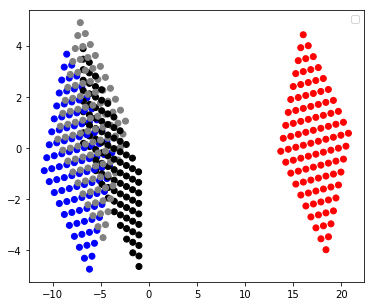

In [31]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

values = []
colors = []
color_dict = {(0,0) : 'black', (1,0): 'blue', (0,1): 'red', (1,1): 'gray'}
for index in np.ndindex(num_row, num_col, 2, 2):
    values.append(predicted_embedding(np.asarray(index), end_state))
    colors.append(color_dict[index[2:]])
values = np.vstack(values)

X = PCA().fit_transform(values)

plt.figure(figsize=(6, 5))
plt.scatter(X[:,0], X[:,1], c=colors)
plt.legend()
plt.show()

